<p style="text-align:right">
    项目名称：<b>人脸识别</b><br/>
设计：董相志<br/>
学号：220100<br/>
日期：2020.10<br/></p>

# 第二阶段：建立人脸识别模型

### 模仿VGG-16模型的结构，自定义一个CNN网络，完成人脸识别的模型训练工作

### 工作步骤：
【1】根据第一阶段采集的数据，用数据增强方法构建训练集与验证集。<br/>
【2】自定义<b> VGG-Face </b>模型<br/>
【3】模型训练<br/>
【4】模型评价<br/>
【5】模型测试<br/>
其实，人脸数据增强需要小心进行，例如不能随意垂直翻转或水平翻转等。此处强调增强，是为了巩固学生处理数据集的能力。

### 2.1 构建训练集和验证集 

第一阶段完成的数据，都是以图片格式分类存放在目录中。目录名称为类别名称。所谓构建训练集与验证集，是指采用一种方法，能够根据模型训练进度的需要，实时、动态、高效加载外部数据。甚至还能够一边加载数据，一边对数据做增强处理。

In [1]:
# 导入库
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, \
                                    Conv2D, MaxPool2D

In [2]:
# 构建训练集和验证集
num_classes = 4  # 类别  （zhou,wu,zheng,wang，或者one、two、three、four）
face_h, face_w = 64, 64  # 头像尺寸，这是为了减少计算量，实践中应该设为128,、160、224等
batch_size = 8   # 因为总的样本数不多，所以批处理设的小一些

train_data_dir = './dataset/train'  # 这是训练集的根目录
validation_data_dir = './dataset/valid'  # 这是验证集的根目录

# 定义数据集加载器，这里只指定了归一化处理参数，其他参数用默认值
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
#  定义数据加载器的工作逻辑
train_generator = train_datagen.flow_from_directory(
        train_data_dir,   # 从哪个目录加载
        target_size=(face_h, face_w),  # 图像缩放尺寸
        batch_size=batch_size,  # 批处理大小
        class_mode='categorical',  # 指定为分类工作模式
        shuffle=True)  # 对加载的数据重新洗牌 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(face_h, face_w),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 211 images belonging to 4 classes.
Found 94 images belonging to 4 classes.


完成了上述工作，现在您可以把注意力放到人脸识别模型上来了！

### 2.2 模仿 VGG-16 模型的结构，自定义CNN模型
<img src = './images/faceModel.JPG' />

这是我们参照VGG的结构给出的一个自定义CNN模型。课堂测试时，为了加快训练速度，观察模型的演示效果，将输入图像的尺寸设为（64,64,3）。事实上，我们前面已经指定了新参数为：<b>face_h, face_w = 64, 64 </b>

In [3]:
# 定义模型
model = Sequential(name = 'Face_Model')

#BLOCK1
# 卷积层1
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu',input_shape = (face_h, face_w, 3)))
model.add(BatchNormalization())
# 卷积层2
model.add(Conv2D(32, (3, 3),  padding = "same", activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


# Block2
# 卷积层3
model.add(Conv2D(64, (3, 3), padding = "same", activation = 'relu'))
model.add(BatchNormalization())
# 卷积层4
model.add(Conv2D(64, (3, 3), padding = "same", activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Block3:
# 卷积层5
model.add(Conv2D(128, (3, 3),  padding = "same", activation = 'relu'))
model.add(BatchNormalization())
# 卷积层6
model.add(Conv2D(128, (3, 3), padding = "same",  activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())

# 全连接层FC：第7层
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# 全连接层FC：第8层
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# 全连接层FC：第9层，Softmax分类        
model.add(Dense(num_classes, activation = 'softmax'))
          
# 模型结构
model.summary()

Model: "Face_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        2

### 2.3 模型训练

In [4]:
from tensorflow.keras.optimizers import Adam   #优化算法
#回调函数,下面这三个回调函数，可以让学生反复练习，因为几乎每次模型训练，都要用到
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, \
                                        ReduceLROnPlateau

In [5]:
%%time
# 定义回调函数：保存最优模型                     
checkpoint = ModelCheckpoint("./Trained_Models/face_recognition_model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             save_weights_only=False,
                             verbose=1)
# 定义回调函数：提前终止训练
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)
# 定义回调函数：学习率衰减。这是是一个简单策略。还可以定义更复杂的。
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.8,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# 将回调函数组织为回调列表
callbacks = [earlystop, checkpoint, reduce_lr]

# 模型编译，指定损失函数、优化算法、学习率和模型评价标准 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy'])

#训练集样本数量，对训练集规模应该精准把握
n_train_samples = train_generator.n
#验证集样本数量，对验证集规模应该精准把握
n_validation_samples =validation_generator.n
# 训练代数
epochs = 20

# 开始训练
history = model.fit(
    train_generator, # 动态加载训练集   
    steps_per_epoch = n_train_samples // batch_size,  # 控制单代迭代步数
    epochs = epochs,  # 最大训练代数
    callbacks = callbacks,  # 回调函数列表
    validation_data = validation_generator,  # 动态加载验证集
    validation_steps = n_validation_samples // batch_size # 控制单代迭代步数
)

Epoch 1/20
26/26 [==============================] - 20s 73ms/step - loss: 1.0036 - accuracy: 0.6207 - val_loss: 719.8184 - val_accuracy: 0.2727

Epoch 00001: val_loss improved from inf to 719.81842, saving model to ./Trained_Models\face_recognition_model.h5
Epoch 2/20
26/26 [==============================] - 0s 15ms/step - loss: 0.4700 - accuracy: 0.8079 - val_loss: 27.2384 - val_accuracy: 0.1705

Epoch 00002: val_loss improved from 719.81842 to 27.23841, saving model to ./Trained_Models\face_recognition_model.h5
Epoch 3/20
26/26 [==============================] - 0s 14ms/step - loss: 0.5325 - accuracy: 0.8325 - val_loss: 19.6495 - val_accuracy: 0.2614

Epoch 00003: val_loss improved from 27.23841 to 19.64951, saving model to ./Trained_Models\face_recognition_model.h5
Epoch 4/20
26/26 [==============================] - 0s 14ms/step - loss: 0.3544 - accuracy: 0.8916 - val_loss: 7.3192 - val_accuracy: 0.4318

Epoch 00004: val_loss improved from 19.64951 to 7.31919, saving model to ./Trai

### 2.4 模型评价

通过观察模型训练过程的表现，对模型实施一个基本评估。常用直观的指标有准确率曲线与损失函数曲线。

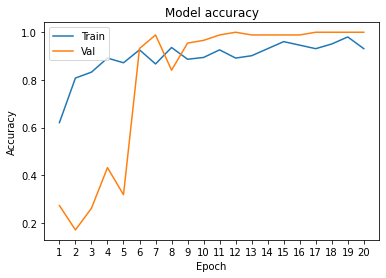

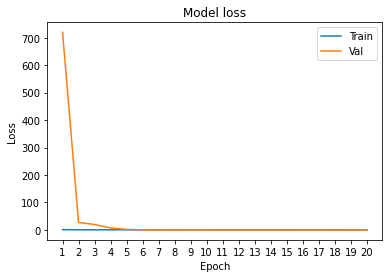

In [6]:
#绘制模型准确率曲线
import matplotlib.pyplot as plt
x = range(1, len(history.history['accuracy'])+1)
plt.plot(x, history.history['accuracy'])
plt.plot(x, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(x)
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
#绘制模型损失函数曲线
plt.plot(x, history.history['loss'])
plt.plot(x, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.legend(['Train', 'Val'], loc='upper right')

这个损失函数曲线有些迷惑性，不仔细看，容易被欺骗。原因是坐标相对尺度变化太大了。

无论是准确率曲线还是损失函数曲线，都会给我们一个基本提示,例如：<br/>
【1】<b>模型过拟合吗？</b><br/>
【2】<b>模型准确率高吗？</b><br/>
【3】<b>稳定吗？泛化能力强吗？</b><br/>
【4】<b>有提升空间吗？有哪些提升措施？</b><br/>
【5】<b>可以部署到生产实践场景中吗？距离还有多远？</b><br/>

### 2.5 模型测试

In [7]:
# 获取标签列表，对标签做个观察
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
class_labels

{0: 'four', 1: 'one', 2: 'three', 3: 'two'}

#### 基于摄像头测试模型

#### 模型训练完成后，可以直接从此处开始加载模型测试。
所以有几个包重新导入一遍，以便可以确定从此处开始运行测试。

In [8]:
# 加载训练好的模型
from tensorflow.keras.models import load_model
model = load_model('./Trained_Models/face_recognition_model.h5')

In [9]:
import cv2
import numpy as np
import dlib

In [11]:
# 定义模型的标签字典
face_classes = {0: 'four', 1: 'one', 2: 'three', 3: 'two'}
    
# dlib脸部检测器
detector = dlib.get_frontal_face_detector()
# 打开摄像头
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()  # 读取一帧
    preprocessed_faces = []   # 脸部图像列表，用于保存当前帧检测到的全部face图像        
    frame_h, frame_w, _ = np.shape(frame)  # 帧图像大小
    detected = detector(frame, 1)  #探测脸部
    
    if len(detected) > 0:  #提取当前帧探测的所有脸部图像，构建预测数据集
        for i, d in enumerate(detected):  #枚举脸部对象
            #脸部坐标
            x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1,\
            d.width(), d.height()
            
            # 绘制边界框
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # 脸部的边界（含边距）
            face =  frame[y1:y2 + 1, x1:x2 + 1, :]
            # 脸部缩放，以适合模型需要的输入维度
            face = cv2.resize(face, (face_h, face_w))
            # 图像归一化
            face = face.astype("float") / 255.0
            # 扩充维度，变为四维（1，face_h,face_w,3）
            face = np.expand_dims(face, axis=0)
            # 加入预处理的脸部图像列表
            preprocessed_faces.append(face)

        # 对每一个face进行预测，可以同时识别多个人像 
        face_labels = []  #保存预测结果
        for i, d in enumerate(detected):
            preds = model.predict(preprocessed_faces[i])[0]  #预测
            face_labels.append(face_classes[preds.argmax()])  # 提取标签
            label = f"{face_labels[i]}"
            cv2.putText(frame,label,(d.left(),d.top()-10),cv2.FONT_HERSHEY_SIMPLEX,1.2,(255, 255,0),3)

    cv2.imshow("Face Recognition", frame)  # 显示当前帧
    # Esc键终止检测
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()      

按ESC键可以结束实时监测。观察检测结果，你有什么想说的吗？

模型可能有些准，又有些不准。很大程度上取决于你的数据集。

回顾建模模型过程，写出分析总结报告。

思考：该模型的最大缺点是什么？<br/>
回答：增加新员工，需要重新训练模型。<font color='red'>这可不太友好吆！！！！</font><br/>
那么，如何改进呢？

### 请继续完成第三阶段的学习，相似度检测。